1. Data processing :
two files to be processes : temperature file and population file

In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
from importlib import reload
import functions as f
from tqdm import tqdm
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
reload(f)

<module 'functions' from 'c:\\Users\\croge\\OneDrive\\Documents\\cours EPFL\\MA3\\ML_project\\UHI_prediction\\functions.py'>

In [31]:
#pop_day_europe = rio.open(r'data_population_day\ENACT_POP_D072011_EU28_R2020A_4326_30ss_V1_0.tif')
#pop_night_europe = rio.open(r'data_night_30ss\ENACT_POP_N072011_EU28_R2020A_4326_30ss_V1_0.tif')

land_cover = rio.open(r"MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif")

elevation1 = rio.open(r'elevation\30N000E_20101117_gmted_mea300.tif')
elevation2 = rio.open(r'elevation\30N030W_20101117_gmted_mea300.tif')
elevation3 = rio.open(r'elevation\50N000E_20101117_gmted_mea300.tif')
elevation4 = rio.open(r'elevation\50N030W_20101117_gmted_mea300.tif')

NDVI = xr.open_dataset(r'NDVI\c_gls_NDVI_201406110000_GLOBE_PROBAV_V2.2.1.nc')

vienna_tas = xr.open_dataset(r'data_cities\vienna_data\tas_Vienna_UrbClim_2011_08_v1.0.nc')

elev_list = [elevation1,elevation2,elevation3,elevation4]
folder = 'data_cities'

In [32]:
elevation = rio.open(r'elevation\elevation_merged.tif') 
cities = ['Amsterdam', 'Madrid', 'Stockholm', 'Lyon', 'Vienna']

In [201]:
reload(f)
#city_df = f.process_data(elevation, land_cover, NDVI, 40000, cities=cities)
city_df_interp = pd.read_csv('data_cities/city_df_interp.csv')
#city_df.to_csv('data_cities\city_df.csv')

In [123]:
#city_df_interp = f.process_data(elevation, land_cover, NDVI, 40000, cities=cities, interpolation=True) #interpolation parameter chooses the method of upsampling
#city_df_interp.to_csv('data_cities\city_df_interp.csv')

In [202]:
latitudes = {'Amsterdam' : 52.377956, 'Madrid' : 40.416775, 'Stockholm' : 59.329323, 'Lyon' : 45.764043, 'Vienna' : 48.208174}
#add a column with the latitude of the city
city_df_interp['latitude'] = city_df_interp['city'].map(latitudes)
#remplace negative pop values with 0
city_df_interp['pop'] = city_df_interp['pop'].apply(lambda x: 0 if x < 0 else x)
city_df_interp.head()

,Unnamed: 0,temp,pop,wind,hum,deltaT,hour,month,elevation,city,land cover type,NDVI,isrural,latitude
0,0,276.45795,3335.140848,2.073505,86.510470,0.708160,0,1,0,Amsterdam,22,0.636830,NaN,52.377956
1,1,273.60233,401.735647,1.720720,89.044340,-0.409088,22,1,1,Amsterdam,18,0.705246,1.0,52.377956
2,2,278.21430,0.768097,4.584240,86.296180,0.209229,11,1,0,Amsterdam,31,0.827180,1.0,52.377956
3,3,274.55290,4.559323,1.749127,89.163864,-0.235565,7,1,0,Amsterdam,2,0.736148,1.0,52.377956
4,4,277.33792,0.000000,3.725439,89.338380,0.411987,10,1,-2,Amsterdam,31,0.908003,NaN,52.377956


In [203]:
city_df_interp.fillna(0, inplace=True)
city_df_interp.describe().loc[:,'pop']

count    2.215107e+06
mean     1.355835e+03
std      2.953738e+03
min      0.000000e+00
25%      4.944234e+00
50%      1.696503e+02
75%      1.207084e+03
max      3.562126e+04
Name: pop, dtype: float64

array([<Axes: title={'center': 'NDVI'}>], dtype=object)

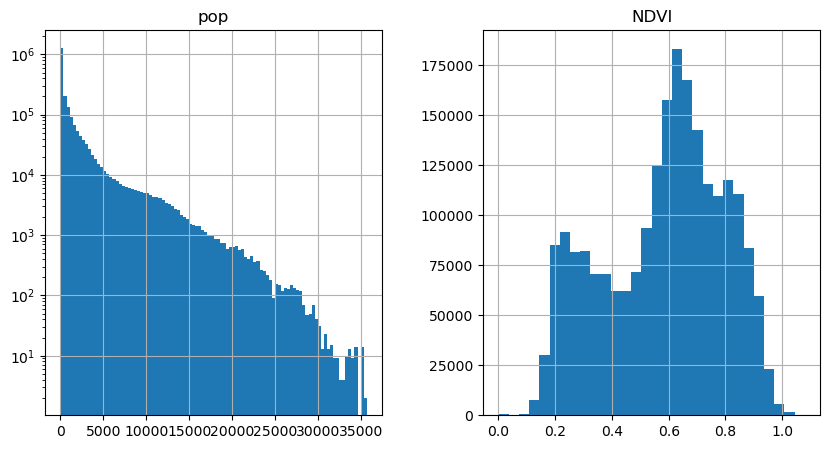

In [204]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
city_df_interp.hist(column='pop', bins=100, log=True, ax=axs[0])
city_df_interp.hist(column='NDVI', bins=30, ax=axs[1])


Lets do some exploratory data analysis on the data first

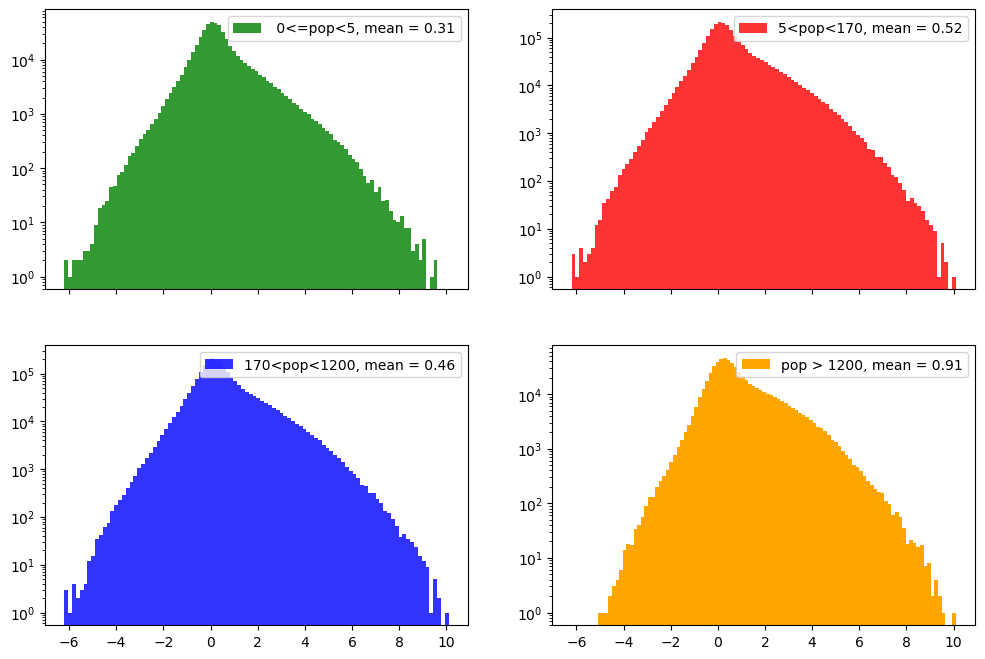

In [205]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


axs[0,1].hist(city_df_interp[(city_df_interp['pop']>=2) & city_df_interp['pop']<115]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'red', label =  f'5<pop<170, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>=2) & city_df_interp["pop"]<115]["deltaT"]):.2f}')
axs[0,1].legend()
axs[0,0].hist(city_df_interp[(city_df_interp["pop"]>=0) & (city_df_interp["pop"]<2)]["deltaT"], log=True, bins = 100, color = 'green', alpha = 0.8, label = f' 0<=pop<5, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>0) & (city_df_interp["pop"]<2)]["deltaT"]):.2f}')
axs[0,0].legend()
axs[1,0].hist(city_df_interp[(city_df_interp['pop']>115) & city_df_interp['pop']<1083]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'blue', label =  f'170<pop<1200, mean = {np.mean(city_df_interp[(city_df_interp["pop"]>115) & (city_df_interp["pop"]<1083)]["deltaT"]):.2f}')
axs[1,0].legend()
axs[1,1].hist(city_df_interp[city_df_interp['pop']>1083]['deltaT'], log=True, bins = 100, alpha = 1, color = 'orange', label =  f'pop > 1200, mean = {np.mean(city_df_interp[city_df_interp["pop"]>1083]["deltaT"]):.2f}')
axs[1,1].legend()


plt.show()


In [206]:
city_df_interp['NDVI'].describe()

count    2.215107e+06
mean     5.814551e-01
std      2.113173e-01
min      0.000000e+00
25%      4.151078e-01
50%      6.147704e-01
75%      7.424576e-01
max      1.079634e+00
Name: NDVI, dtype: float64

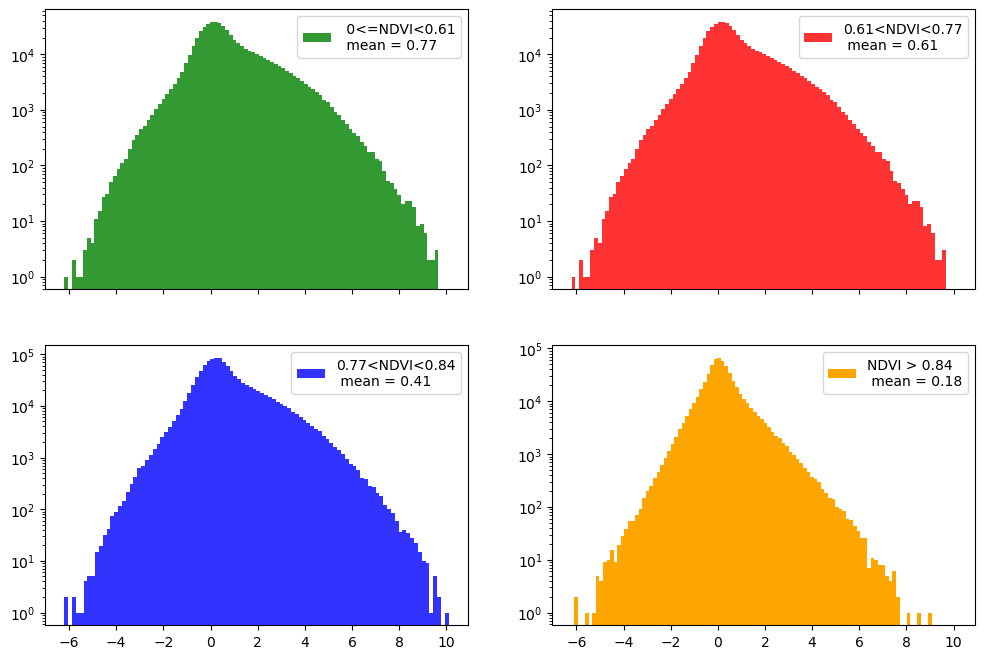

In [207]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


axs[0,1].hist(city_df_interp[(city_df_interp['NDVI']>=0.41) & city_df_interp['NDVI']<0.61]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'red', label =  f'0.61<NDVI<0.77\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>=0.41) & city_df_interp["pop"]<0.61]["deltaT"]):.2f}')
axs[0,1].legend()
axs[0,0].hist(city_df_interp[(city_df_interp["pop"]>=0) & (city_df_interp["NDVI"]<0.41)]["deltaT"], log=True, bins = 100, color = 'green', alpha = 0.8, label = f' 0<=NDVI<0.61\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>0) & (city_df_interp["NDVI"]<0.41)]["deltaT"]):.2f}')
axs[0,0].legend()
axs[1,0].hist(city_df_interp[(city_df_interp['NDVI']>0.61) & city_df_interp['NDVI']<0.74]['deltaT'], log=True, bins = 100, alpha = 0.8, color = 'blue', label =  f'0.77<NDVI<0.84\n mean = {np.mean(city_df_interp[(city_df_interp["NDVI"]>0.61) & (city_df_interp["NDVI"]<0.74)]["deltaT"]):.2f}')
axs[1,0].legend()
axs[1,1].hist(city_df_interp[city_df_interp['NDVI']>=0.74]['deltaT'], log=True, bins = 100, alpha = 1, color = 'orange', label =  f'NDVI > 0.84\n mean = {np.mean(city_df_interp[city_df_interp["NDVI"]>=0.74]["deltaT"]):.2f}')
axs[1,1].legend()


plt.show()


Text(0.5, 1.0, 'Avg DeltaT vs NDVI')

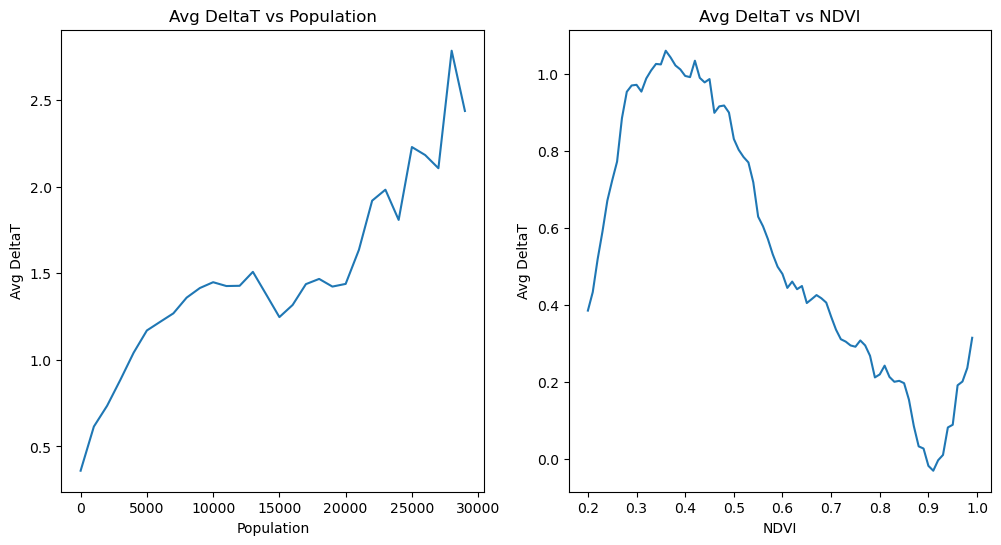

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#create a list of tuples with population intervals
pop_intervals = [(i,i+1000) for i in range(0, 30000, 1000)]
#compute the avg detlaT for each population interval
deltaT_list = [np.mean(city_df_interp[(city_df_interp['pop']>i) & (city_df_interp['pop']<j)]['deltaT']) for i,j in pop_intervals]
#plot the avg deltaT for each population interval
axs[0].plot([i for i,j in pop_intervals], deltaT_list)
axs[0].set_xlabel('Population')
axs[0].set_ylabel('Avg DeltaT')
axs[0].set_title('Avg DeltaT vs Population')

#create a list of tuples with NDVI intervals (between 0 and 1)
NDVI_intervals = [(i/100, (i+1)/100) for i in range(20, 100)]
#compute the avg detlaT for each population interval
deltaT_list = [np.mean(city_df_interp[(city_df_interp['NDVI']>i) & (city_df_interp['NDVI']<j)]['deltaT']) for i,j in NDVI_intervals]
#plot the avg deltaT for each NDVIulation interval
axs[1].plot([i for i,j in NDVI_intervals], deltaT_list)
axs[1].set_xlabel('NDVI')
axs[1].set_ylabel('Avg DeltaT')
axs[1].set_title('Avg DeltaT vs NDVI')


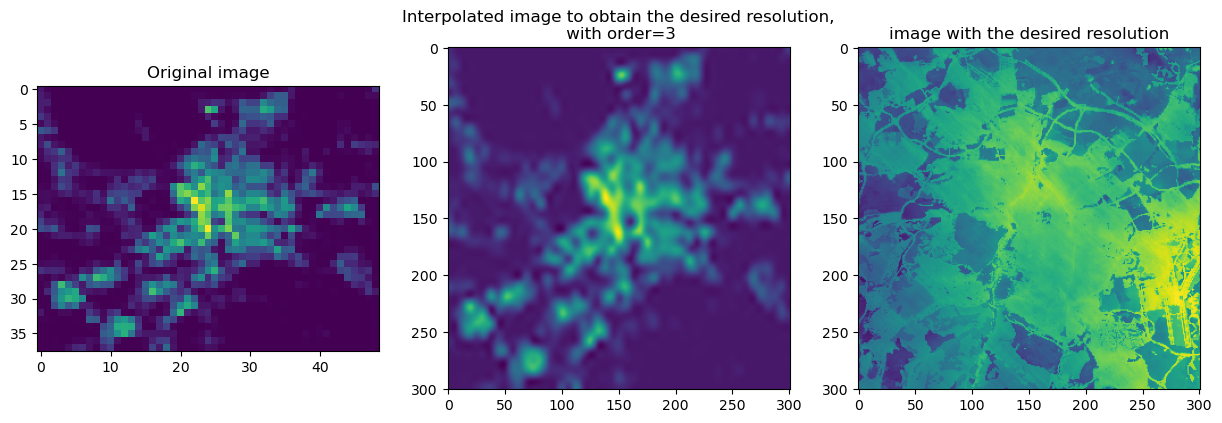

In [209]:
#method of interpolation

import numpy as np
import scipy.ndimage

temp_madrid = xr.open_dataset(r'data_cities\madrid_data\tas_Madrid_UrbClim_2011_09_v1.0.nc')
pop_day_m = rio.open(r'data_population_day\ENACT_POP_D092011_EU28_R2020A_4326_30ss_V1_0.tif')

pop_day_m = f.crop_image(pop_day_m, temp_madrid)
x = pop_day_m


#subplot of the original image and interpolated image
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(x)
axs[0].set_title('Original image')
axs[1].imshow(scipy.ndimage.zoom(x, (301/x.shape[0], 301/x.shape[1]), order=3))
axs[1].set_title('Interpolated image to obtain the desired resolution,\n with order=3')
axs[2].imshow(temp_madrid['tas'][0,:,:])
axs[2].set_title('image with the desired resolution')
plt.show()


In [333]:
#store the quartiles of the deltaT
q1 = city_df_interp['deltaT'].quantile(0.25)
q2 = city_df_interp['deltaT'].quantile(0.50)
q3 = city_df_interp['deltaT'].quantile(0.75)


quant = [q1,q2,q3]


In [335]:
#create a column with population category : 0 for pop<100, 2 for 100<pop<1000, 2 for 1000<pop<100000, 3 for pop>100000 and a deltaT category : 0 for deltaT<q1, 1 for q1<deltaT<q2, 2 for q2<deltaT<q3, 3 for deltaT>q3
city_df_interp['pop_cat'] = city_df_interp['pop'].apply(lambda x : 0 if x<100 else (1 if x<1000 else (2 if x<10000 else 3)))
city_df_interp['deltaT_cat'] = city_df_interp['deltaT'].apply(lambda x : 0 if x<=q1 else (1 if x<=q2 else (2 if x<=q3 else 3)))

In [336]:
city_df_interp.fillna(0, inplace=True) #replace NaN values by 0 (only happens for the isrural column)


In [337]:
#Linear regression using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

city_df_test = city_df_interp[city_df_interp['city'] != 'Lyon'].sample(300000) #we choose a sample of 300000 datapoints to train the model, excluding Lyon

X = city_df_test[city_df_test['isrural'] == 0][['pop', 'elevation', 'land cover type', 'hum', 'wind','month', 'NDVI', 'pop_cat', 'temp', 'latitude', 'deltaT_cat']]
y = city_df_test[city_df_test['isrural'] == 0]['deltaT']

#standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[['pop', 'elevation', 'hum', 'wind', 'NDVI', 'temp']] = scaler.fit_transform(X[['pop', 'elevation', 'hum', 'wind', 'NDVI', 'temp']])

#sample the data so that we have equal number of samples per category of deltaT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#remove deltaT_cat from the data
X_train.drop(columns=['deltaT_cat'], inplace=True)
X_test.drop(columns=['deltaT_cat'], inplace=True)




'''#sample the data to have equal data per category of population
X_sampled = pd.DataFrame(columns = X.columns)
for i in range(4):
    X_sampled = pd.concat([X_sampled, X_train[X_train['pop_cat']==i].sample(100000)])

indexes = X_sampled.index
y_sampled = y_train.loc[indexes]'''


"#sample the data to have equal data per category of population\nX_sampled = pd.DataFrame(columns = X.columns)\nfor i in range(4):\n    X_sampled = pd.concat([X_sampled, X_train[X_train['pop_cat']==i].sample(100000)])\n\nindexes = X_sampled.index\ny_sampled = y_train.loc[indexes]"

# Multi-layer Perceptron regressor

MLP are a category of machine learning algorithm consisting in at least 3 layers of fully interconnected neurons. Learning occurs by changing the connection weights base on the error between the predicted and the actual output. The backpropagation algorithm is used to calculate the error and update the weights. The major disadvantage of MLP is that it is very computationally expensive to train. Here is a schema of an MLP regressor from Skiba (2020)
<p align="center">
  <img src="Example-of-multilayer-perceptron-MLP-network-for-regression-analysis-here-n-13-and.png" />
</p>


In [214]:
#Implement MLP regressor
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(max_iter=500, hidden_layer_sizes=(100),
                    activation='relu', verbose=True, solver='adam',
                    alpha=0.0001, random_state=42, tol = 10e-5, learning_rate_init=0.001,
                    learning_rate='adaptive', warm_start=True, epsilon=0.001, early_stopping=True,
                    validation_fraction=0.1, n_iter_no_change=10,
                    )

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))




Iteration 1, loss = 0.58448196
Validation score: 0.374489
Iteration 2, loss = 0.39570384
Validation score: 0.397051
Iteration 3, loss = 0.37090368
Validation score: 0.428523
Iteration 4, loss = 0.35697643
Validation score: 0.459937
Iteration 5, loss = 0.34217191
Validation score: 0.480040
Iteration 6, loss = 0.33486028
Validation score: 0.476349
Iteration 7, loss = 0.32338046
Validation score: 0.523745
Iteration 8, loss = 0.31483790
Validation score: 0.514447
Iteration 9, loss = 0.31082704
Validation score: 0.547772
Iteration 10, loss = 0.30489292
Validation score: 0.538307
Iteration 11, loss = 0.30369427
Validation score: 0.513990
Iteration 12, loss = 0.29862334
Validation score: 0.502048
Iteration 13, loss = 0.29489934
Validation score: 0.555276
Iteration 14, loss = 0.29190545
Validation score: 0.571892
Iteration 15, loss = 0.29240208
Validation score: 0.573377
Iteration 16, loss = 0.28719586
Validation score: 0.565755
Iteration 17, loss = 0.28580978
Validation score: 0.563764
Iterat

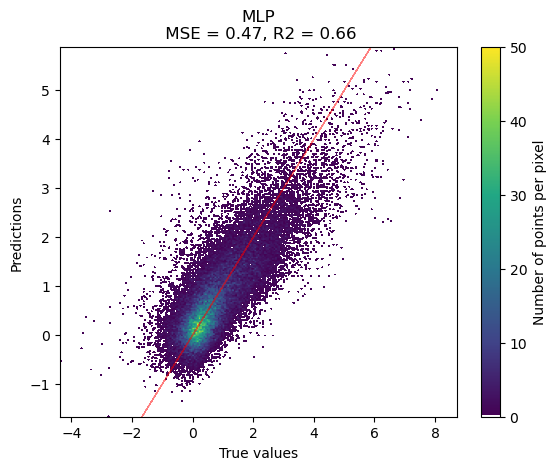

In [215]:
#plot the predictions vs the true values
fig = plt.figure()
f.using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'MLP\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='red', linewidth=.5, alpha = 0.5)
fig.show()

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   20.4s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


MSE:  0.37152886352191755
R2:  0.7258713885252233


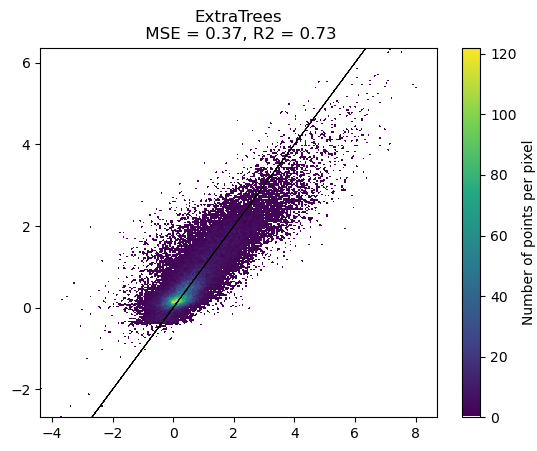

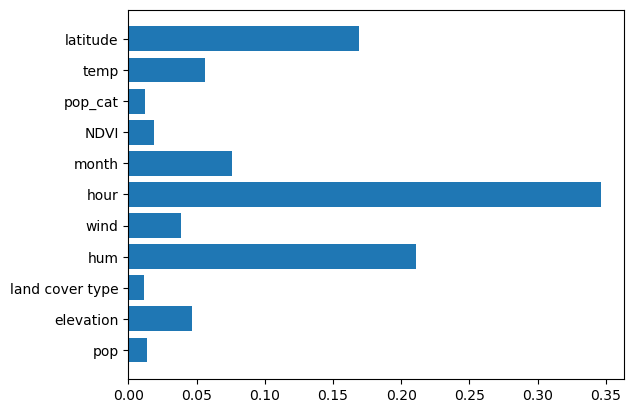

In [217]:
#extra trees
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(random_state=42, n_jobs=1, n_estimators=100, max_depth=15, min_samples_split=2, max_features=10, verbose=2)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

#print variance and bias
fig = plt.figure()
f.using_mpl_scatter_density(fig,y_test, y_pred)
plt.plot(y_test, y_test, color='black', linewidth=.5, linestyle='dashed')
plt.title(f'ExtraTrees\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.show()


#plot feature importance
plt.figure()
plt.barh(X_train.columns, et.feature_importances_)
plt.show()



# Gradient Boosting regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The sklearn histGradientBoostingRegressor is based on the LightGBM method that uses an histogram based method to bin the features, therefore using less memory and being faster than the classical gradient boosting method. Here is a schema of the gradient boosting algorithm.
<p align="center">
  <img src="Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png" />
</p>


Binning 0.010 GB of training data: 0.216 s
Binning 0.001 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.61525, val loss: 0.60890, in 0.022s
[2/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.56150, val loss: 0.55633, in 0.023s
[3/1000] 1 tree, 31 leaves, max depth = 9, train loss: 0.51651, val loss: 0.51203, in 0.020s
[4/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.47933, val loss: 0.47628, in 0.020s
[5/1000] 1 tree, 31 leaves, max depth = 9, train loss: 0.44817, val loss: 0.44569, in 0.119s
[6/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.42300, val loss: 0.42077, in 0.203s
[7/1000] 1 tree, 31 leaves, max depth = 11, train loss: 0.40099, val loss: 0.39963, in 0.084s
[8/1000] 1 tree, 31 leaves, max depth = 10, train loss: 0.38219, val loss: 0.38131, in 0.039s
[9/1000] 1 tree, 31 leaves, max depth = 9, train loss: 0.36594, val loss: 0.36535, in 0.056s
[10/1000] 1 tree, 31 leaves, max depth =

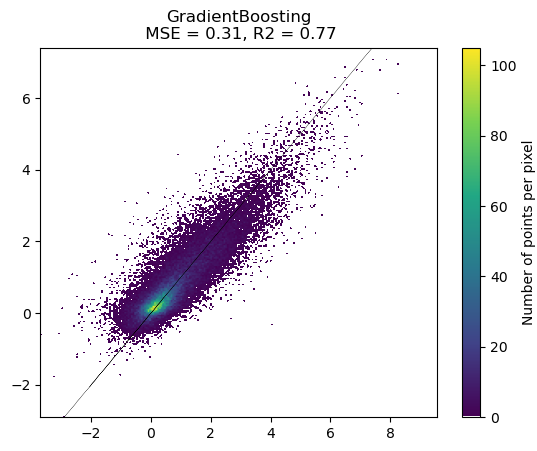

In [338]:
#Gradient boosting (wihtout deltaT_cat)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

gb = HistGradientBoostingRegressor(random_state=42, max_depth=20, learning_rate=0.1, min_samples_leaf=2, max_iter=1000, verbose=1, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=10e-5)    


gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

fig = plt.figure()
f.using_mpl_scatter_density(fig, y_test, y_pred)
plt.title(f'GradientBoosting\n MSE = {round(mean_squared_error(y_test, y_pred), 2)}, R2 = {round(r2_score(y_test, y_pred), 2)}')
plt.plot(y_test, y_test, color='black', linestyle='dashed', linewidth=.2)

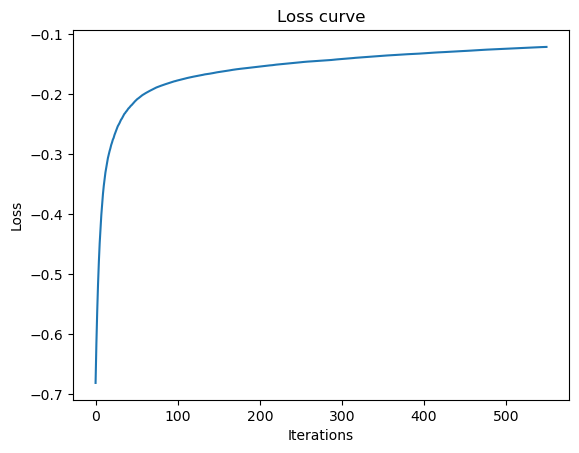

In [339]:
#plot loss curve
plt.figure()
plt.plot(gb.train_score_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()


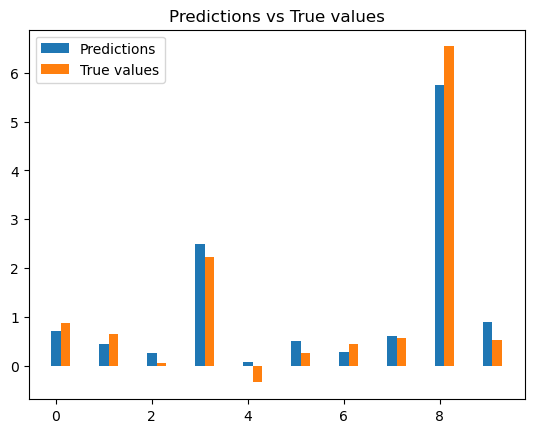

In [341]:
bar_width = 0.2
plt.bar(range(10), gb.predict(X_test.iloc[150:160]), width=bar_width, label='Predictions')
plt.bar(np.arange(10)+bar_width, y_test.iloc[150:160], width=bar_width, label='True values')
plt.title('Predictions vs True values')
plt.legend()
plt.show()

In [342]:
#export the model
'''import pickle
filename = 'finalized_model.sav'
pickle.dump(model_final, open(filename, 'wb'))'''

model_deltaT = pickle.load(open('finalized_model.sav', 'rb'))
reload(f)

<module 'functions' from 'c:\\Users\\croge\\OneDrive\\Documents\\cours EPFL\\MA3\\ML_project\\UHI_prediction\\functions.py'>

Number of nan values in deltaT:  51922
Number of nan values in deltaT_predicted:  51922


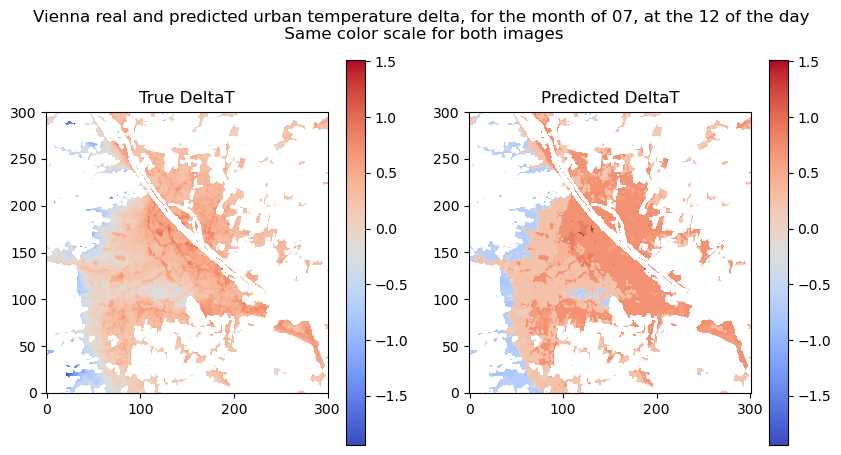

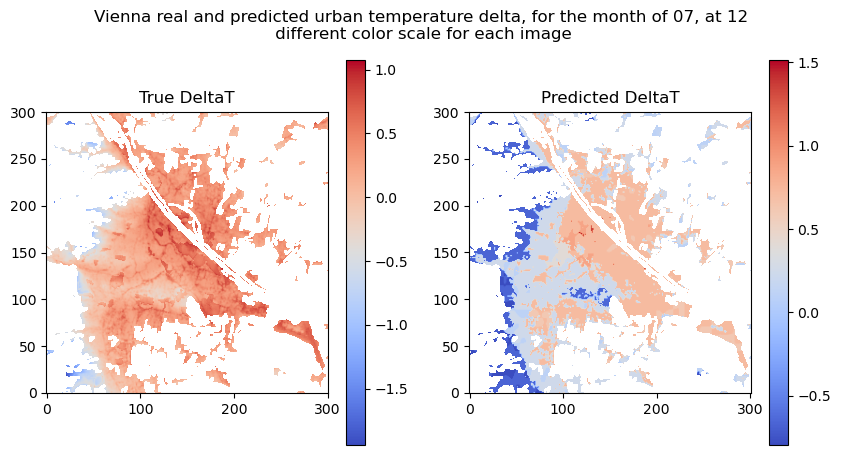

In [344]:
#visualize the prediction for a city, month and given hour (in the training set)
deltat, predictedDT, _, _ = f.visualization_prediction('Vienna', 24*12+12, model_deltaT, 7, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=True)

Number of nan values in deltaT:  50317
Number of nan values in deltaT_predicted:  50317


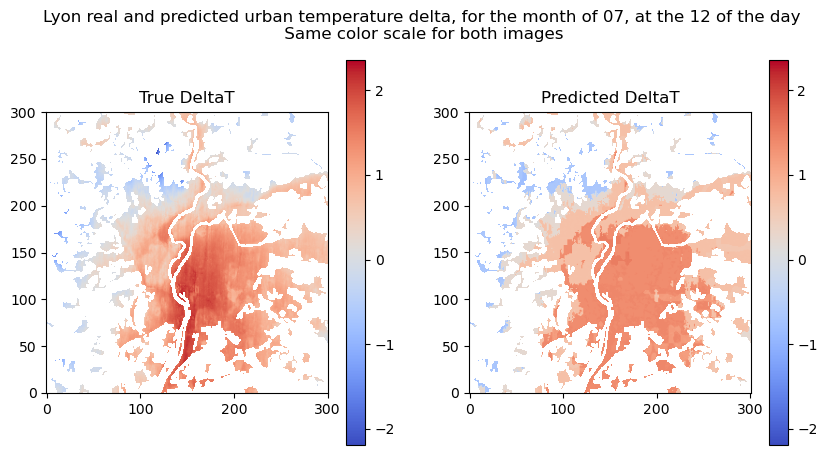

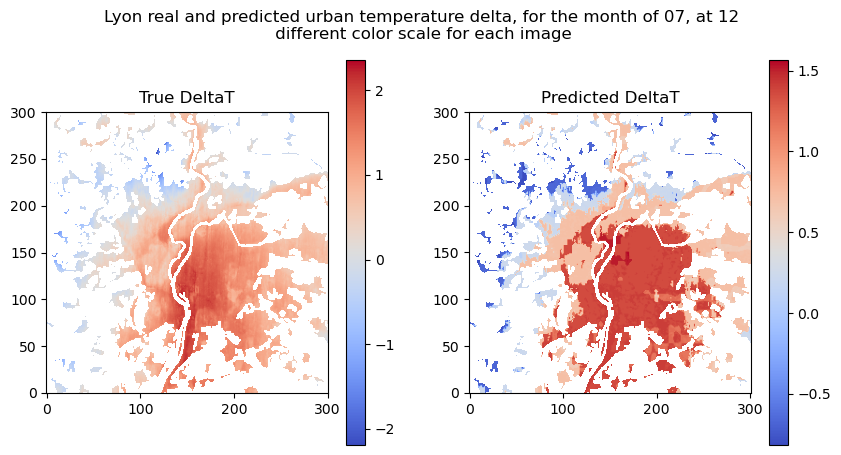

In [345]:
#Visualize the prediction for a city, month and given hour (not in the train set)
deltat, predictedDT, _, _ = f.visualization_prediction('Lyon', 24*12+12, model_deltaT, 7, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=True)

## Analysis

The model is not good at predicting precisely contours of the UHIs but more to give an average magnitude over all urban pixels. This is due to the disparity in the distribution of the magnitude of UHIs.

By adding add a small 'helping' categorical variable that indicates the model what is the magnitude category of the UHI, the results obtained are much more precise. A simple division of the temperature in 4 categories (based on the quartiles of the the distribution of the train set) permits to obtain a R^2 of.9 and a MSE of .2, and the visualization is much more interesting

In [346]:
model_final = pickle.load(open('finalized_model.sav', 'rb'))
city_df_interp = pd.read_csv('data_cities/city_df.csv')

latitudes = {'Amsterdam' : 52.377956, 'Madrid' : 40.416775, 'Stockholm' : 59.329323, 'Lyon' : 45.764043, 'Vienna' : 48.208174}
#add a column with the latitude of the city
city_df_interp['latitude'] = city_df_interp['city'].map(latitudes)

q1 = city_df_interp['deltaT'].quantile(0.25)
q2 = city_df_interp['deltaT'].quantile(0.5)
q3 = city_df_interp['deltaT'].quantile(0.75)


Number of nan values in deltaT:  51922
Number of nan values in deltaT_predicted:  51922


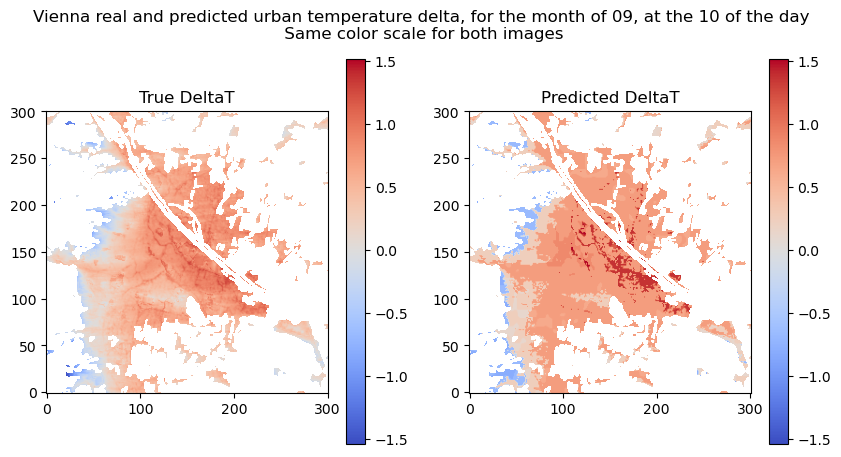

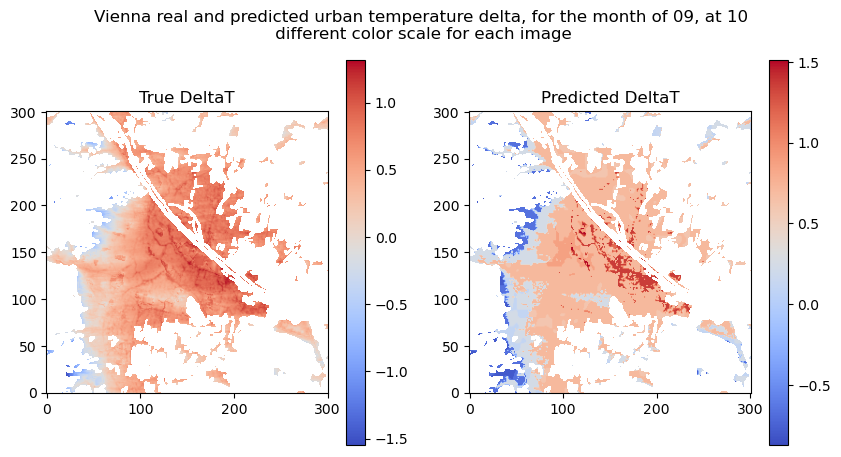

In [347]:
#1. for a city in the training set (need to use a model that was trained with the deltaT cat in the first place)
deltat, predictedDT, _, _ = f.visualization_prediction('Vienna', 24*12+10, model_deltaT, 9, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=True)

Number of nan values in deltaT:  50317
Number of nan values in deltaT_predicted:  50317


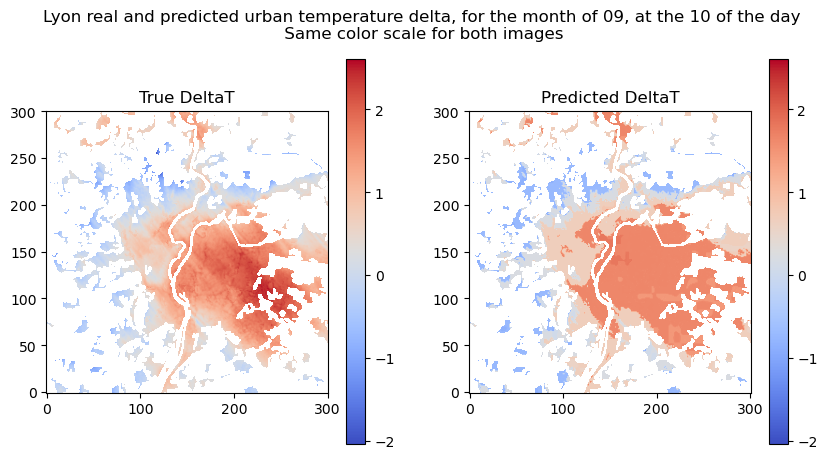

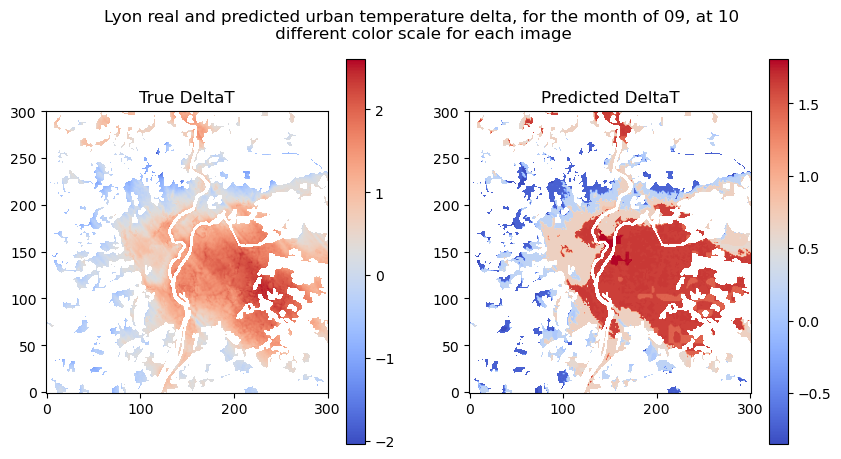

In [350]:
#2. for a city not in the training set
deltat, predictedDT, _, _ = f.visualization_prediction('Lyon', 24*12+10, model_final, 9, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=True)

we can check if we can predict the deltaT catergory with a somehow high accuracy

deltaT_cat
0    49152
1    55768
2    51976
3    43104
Name: latitude, dtype: int64


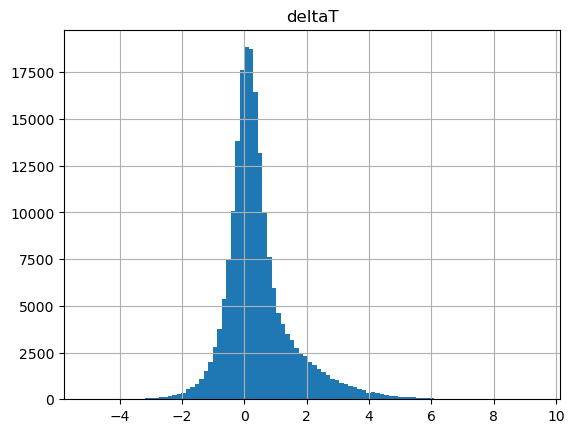

In [351]:
from sklearn.model_selection import train_test_split
#we can try to predict the category of deltaT for a city tho
test_df = city_df_interp[city_df_interp['city'] != 'Lyon'].sample(200000)

test_df.hist(column='deltaT', bins=100)

test_df['deltaT_cat'] = test_df['deltaT'].apply(lambda x : 0 if x<=q1 else (1 if x<=q2 else (2 if x<=q3 else 3 )))
print(test_df.groupby('deltaT_cat')['latitude'].count())
X = test_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'temp', 'latitude']]
y = test_df['deltaT_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)



In [352]:
#import a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
clf_rf = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=42, n_jobs=1, verbose=4, min_samples_split=2, max_features=10)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
print('Accuracy: ', clf_rf.score(X_test, y_test))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))


building tree 1 of 20
building tree 2 of 20


KeyboardInterrupt: 

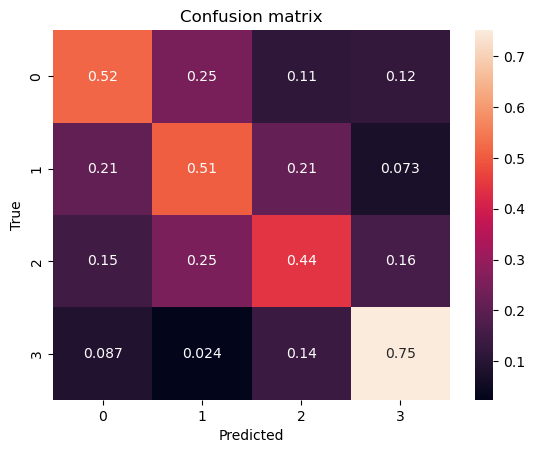

In [253]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

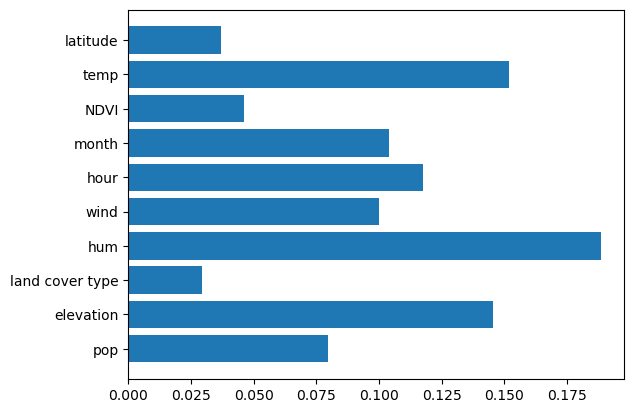

In [254]:
#print feature importance
plt.figure()
plt.barh(X_train.columns, clf.feature_importances_)
plt.show()


Binning 0.012 GB of training data: 0.271 s
Binning 0.001 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
[1/1000] 4 trees, 124 leaves (31 on avg), max depth = 10, train loss: 1.30267, val loss: 1.30542, in 0.162s
[2/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 1.25228, val loss: 1.25639, in 0.129s
[3/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 1.21579, val loss: 1.22130, in 0.128s
[4/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 1.18908, val loss: 1.19488, in 0.120s
[5/1000] 4 trees, 124 leaves (31 on avg), max depth = 11, train loss: 1.16908, val loss: 1.17573, in 0.133s
[6/1000] 4 trees, 124 leaves (31 on avg), max depth = 10, train loss: 1.15170, val loss: 1.15919, in 0.134s
[7/1000] 4 trees, 124 leaves (31 on avg), max depth = 9, train loss: 1.13824, val loss: 1.14634, in 0.113s
[8/1000] 4 trees, 124 leaves (31 on avg), max depth = 11, train loss: 1.12695, val loss: 1.13585, in 0.122s
[9/1000] 4 trees, 1

Text(0.5, 1.0, 'Confusion matrix')

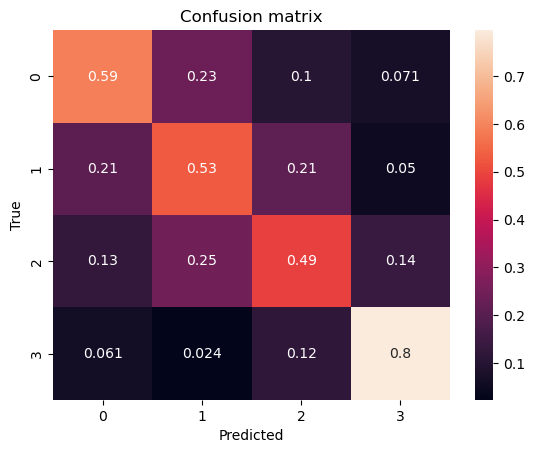

In [353]:
#gradient boosting classifier
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42, max_depth=14, learning_rate=0.15, min_samples_leaf=2, max_iter=1000, 
                                     verbose=0, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=10e-5,
                                     l2_regularization=0.2, warm_start=True, max_bins=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', clf.score(X_test, y_test))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')


In [272]:
final_model_withdtcat = pickle.load(open('finalized_model.sav', 'rb'))
reload(f)

<module 'functions' from 'c:\\Users\\croge\\OneDrive\\Documents\\cours EPFL\\MA3\\ML_project\\UHI_prediction\\functions.py'>

Number of nan values in deltaT:  51922
Number of nan values in deltaT_predicted:  51922


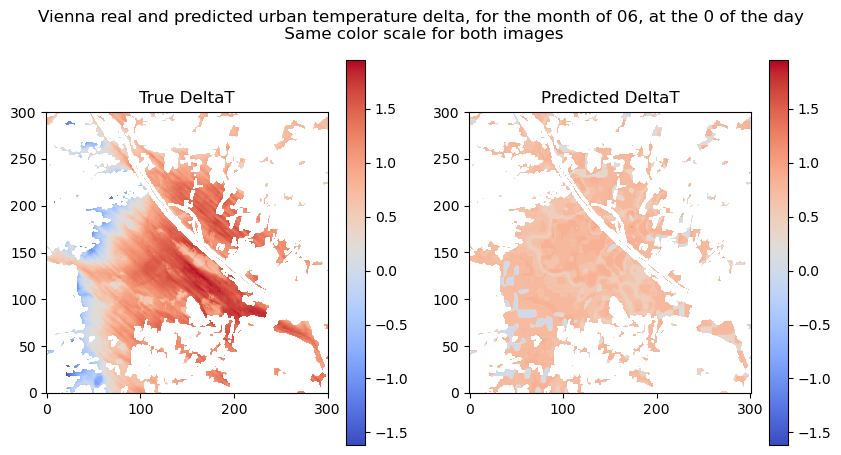

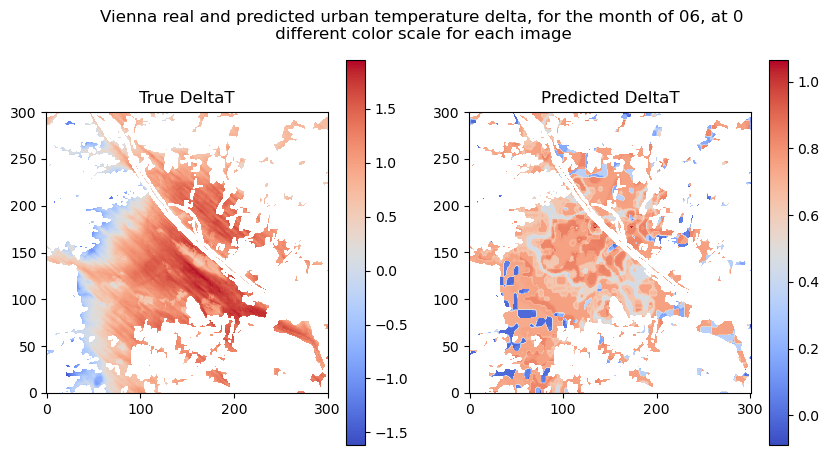

deltaT_cat
0.0     2885
1.0     3563
2.0    12438
3.0    19793
Name: count, dtype: int64
deltaT_cat_predicted
0.0     6844
1.0     1473
2.0    25678
3.0     4684
Name: count, dtype: int64


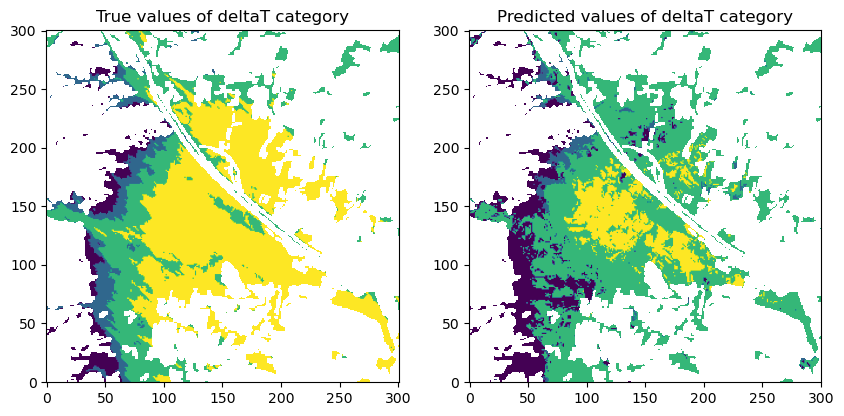

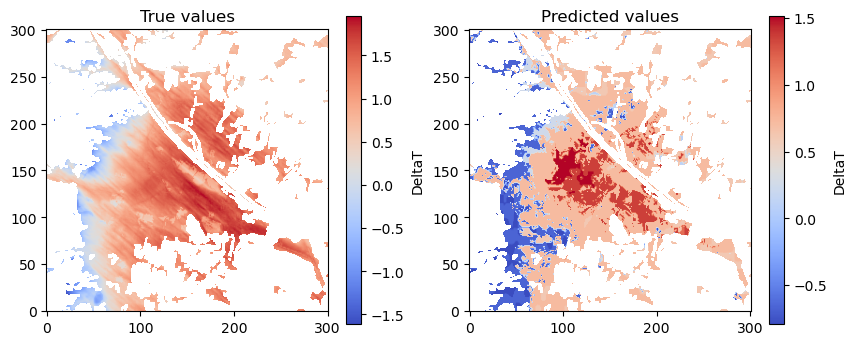

In [364]:
deltaT, predictedDT, madrid_df, shape_city = f.visualization_prediction('Vienna', 24*1+0, gb, 6, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=False)

madrid_df['deltaT_cat_predicted'] = clf.predict(madrid_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'temp', 'latitude']])
madrid_df[madrid_df['iswater'] == 0] = np.nan
madrid_df[madrid_df['isrural'] == 1] = np.nan
print(madrid_df.groupby('deltaT_cat')['deltaT_cat'].value_counts())
print(madrid_df.groupby('deltaT_cat_predicted')['deltaT_cat_predicted'].value_counts())

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(madrid_df['deltaT_cat'].values.reshape(shape_city,shape_city))
ax[0].set_title('True values of deltaT category')
ax[0].invert_yaxis()
ax[1].imshow(madrid_df['deltaT_cat_predicted'].values.reshape(shape_city,shape_city))
ax[1].set_title('Predicted values of deltaT category')
ax[1].invert_yaxis()

plt.show()

madrid_df['deltaT_cat'] = madrid_df['deltaT_cat_predicted']
madrid_df['pop_cat'] = madrid_df['pop'].apply(lambda x : 0 if x<100 else (1 if x<1000 else (2 if x<10000 else 3)))
madrid_df[madrid_df['iswater'] == 0] = np.nan
madrid_df['deltaT_predicted'] = final_model_withdtcat.predict(madrid_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'pop_cat', 'temp', 'latitude', 'deltaT_cat']])

#plot the prediction and the true values with the same color scale
fig, ax = plt.subplots(1,2, figsize=(10,5))

deltaT = madrid_df['deltaT']
deltaT_predicted = madrid_df['deltaT_predicted']
deltaT_predicted[madrid_df['iswater'] != 1] = np.nan
deltaT_predicted[madrid_df['isrural'] != 0] = np.nan

vmin = np.min([deltaT[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].min(), 
                deltaT_predicted[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].min()])
vmax = np.max([deltaT[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].max(), 
                deltaT_predicted[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].max()])


deltaT_predicted = deltaT_predicted.values.reshape(shape_city,shape_city)
ax[0].imshow(madrid_df['deltaT'].values.reshape(shape_city,shape_city), cmap='coolwarm')
ax[0].set_title('True values')
#invert the y axis
#add a colorbar
cbar = plt.colorbar(ax[0].imshow(madrid_df['deltaT'].values.reshape(shape_city,shape_city), cmap='coolwarm'), ax=ax[0], shrink=0.8)
ax[0].invert_yaxis()

cbar.set_label('DeltaT')

ax[1].imshow(deltaT_predicted, cmap='coolwarm')
ax[1].set_title('Predicted values')
#invert the y axis

#add a colorbar
cbar = plt.colorbar(ax[1].imshow(deltaT_predicted, cmap='coolwarm'), ax=ax[1], shrink=0.8)
ax[1].invert_yaxis()
cbar.set_label('DeltaT')

plt.show()


Number of nan values in deltaT:  50317
Number of nan values in deltaT_predicted:  50317


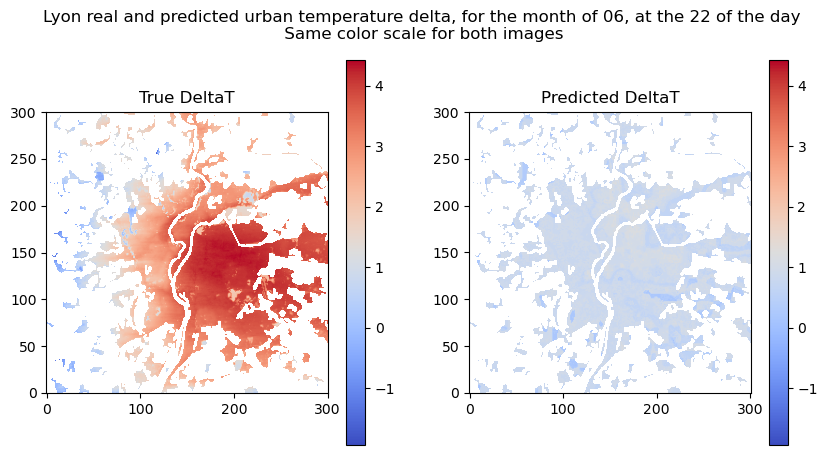

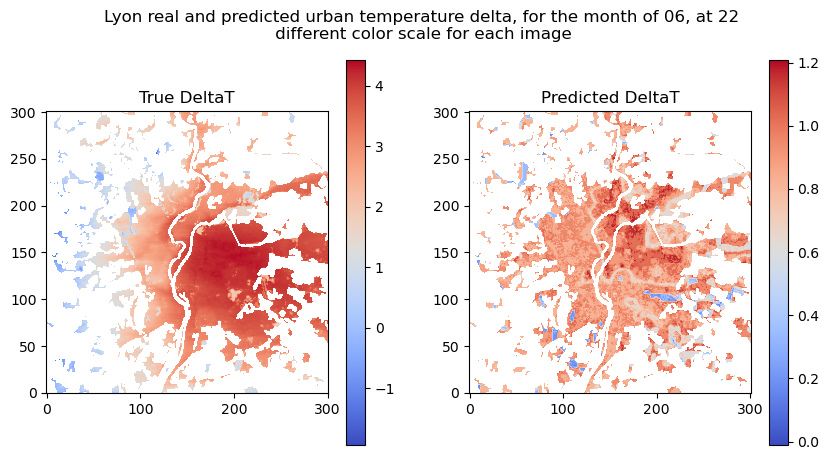

deltaT_cat
0.0      631
1.0      791
2.0     2527
3.0    36335
Name: count, dtype: int64
deltaT_cat_predicted
0.0     5075
1.0       85
2.0      260
3.0    34864
Name: count, dtype: int64


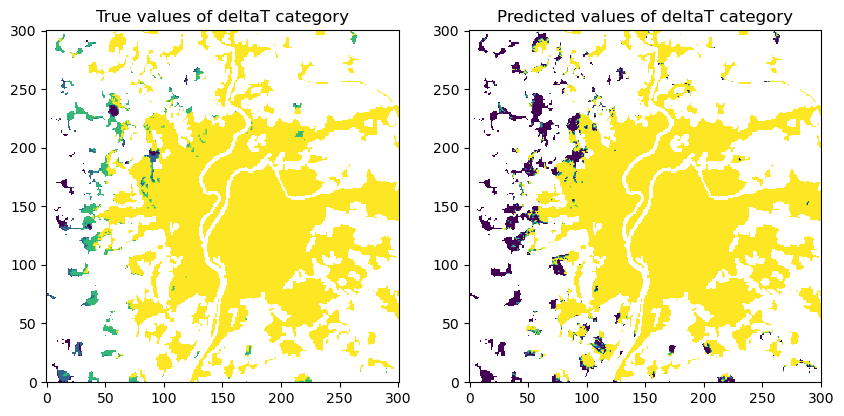

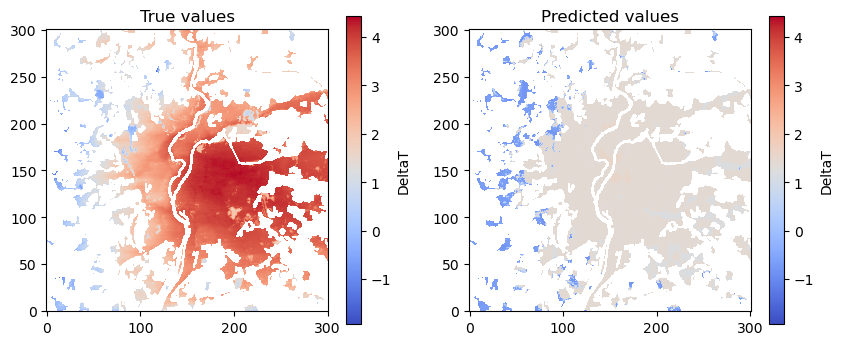

In [370]:
deltaT, predictedDT, madrid_df, shape_city = f.visualization_prediction('Lyon', 24*1+22, gb, 6, [q1, q2, q3], cmap = 'coolwarm', deltaTcat=False)



madrid_df['deltaT_cat_predicted'] = clf.predict(madrid_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'temp', 'latitude']])
madrid_df[madrid_df['iswater'] == 0] = np.nan
madrid_df[madrid_df['isrural'] == 1] = np.nan
print(madrid_df.groupby('deltaT_cat')['deltaT_cat'].value_counts())
print(madrid_df.groupby('deltaT_cat_predicted')['deltaT_cat_predicted'].value_counts())

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(madrid_df['deltaT_cat'].values.reshape(shape_city,shape_city))
ax[0].set_title('True values of deltaT category')
ax[0].invert_yaxis()
ax[1].imshow(madrid_df['deltaT_cat_predicted'].values.reshape(shape_city,shape_city))
ax[1].set_title('Predicted values of deltaT category')
ax[1].invert_yaxis()

plt.show()

madrid_df['deltaT_cat'] = madrid_df['deltaT_cat_predicted']
madrid_df['pop_cat'] = madrid_df['pop'].apply(lambda x : 0 if x<100 else (1 if x<1000 else (2 if x<10000 else 3)))
madrid_df[madrid_df['iswater'] == 0] = np.nan
madrid_df['deltaT_predicted'] = final_model_withdtcat.predict(madrid_df[['pop', 'elevation', 'land cover type', 'hum', 'wind', 'hour','month', 'NDVI', 'pop_cat', 'temp', 'latitude', 'deltaT_cat']])

#plot the prediction and the true values with the same color scale
fig, ax = plt.subplots(1,2, figsize=(10,5))

deltaT = madrid_df['deltaT']
deltaT_predicted = madrid_df['deltaT_predicted']
deltaT_predicted[madrid_df['iswater'] != 1] = np.nan
deltaT_predicted[madrid_df['isrural'] != 0] = np.nan

vmin = np.min([deltaT[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].min(), 
                deltaT_predicted[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].min()])
vmax = np.max([deltaT[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].max(), 
                deltaT_predicted[(madrid_df['iswater']==1) & (madrid_df['isrural']==0)].max()])


deltaT_predicted = deltaT_predicted.values.reshape(shape_city,shape_city)
ax[0].imshow(madrid_df['deltaT'].values.reshape(shape_city,shape_city), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[0].set_title('True values')
#invert the y axis
#add a colorbar
cbar = plt.colorbar(ax[0].imshow(madrid_df['deltaT'].values.reshape(shape_city,shape_city), cmap='coolwarm', vmin=vmin, vmax=vmax), ax=ax[0], shrink=0.8)
ax[0].invert_yaxis()

cbar.set_label('DeltaT')

ax[1].imshow(deltaT_predicted, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[1].set_title('Predicted values')
#invert the y axis

#add a colorbar
cbar = plt.colorbar(ax[1].imshow(deltaT_predicted, cmap='coolwarm', vmin=vmin, vmax = vmax), ax=ax[1], shrink=0.8)
ax[1].invert_yaxis()
cbar.set_label('DeltaT')

plt.show()
